# Figure 3: Explained variance of Denmark Strait freshwater transport reconstructions

This notebook will reproduce Figure 3 from  E. Boland et al. 2025 (doi to come). This requires datafiles containing cumulative explained variance data to run - please see the README for details.

The datafiles specifically required are:
- horflux_fw_denm_cumev_bylag_byvar_{year}.nc and horflux_fw_denm_cumev_bylag_byvar_bymonth_{year}.nc, which it expects to find in {EV_DIR}/{year}, produced by running convolve.py followed by calc_ev.py

Please attribute any plots or code from this notebook using the DOI from Zenodo: https://doi.org/10.5281/zenodo.17225514

E Boland Jan 2025 [emmomp@bas.ac.uk](email:emmomp@bas.ac.uk)

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import cmasher as cmr
import numpy as np
from cycler import cycler
from inputs import EV_DIR, ecco_convs, eyears

In [3]:
plotvars=['all_OCE','wind_OCE','adxx_qnetXoceQnet_sum', 'adxx_empmrXoceFWflx_sum']
plotvar_labels=dict(zip(plotvars,['Total Recon','Wind Stress','Heat','Fresh Water']))

In [4]:
mth=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
mthi=dict(zip(mth,[i for i in range(1,13)]))

In [5]:
cum_ev={}
cum_ev_bym={}
for year in eyears:
        cum_ev[year]=xr.open_dataset(f'{EV_DIR}/{year}/horflux_fw_denm_cumev_bylag_byvar_{year}.nc').assign_coords({'eyear':year})
        cum_ev_bym[year]=xr.open_dataset(f'{EV_DIR}/{year}/horflux_fw_denm_cumev_bylag_byvar_bymonth_{year}.nc').assign_coords({'eyear':year,'lag_years':cum_ev[year].lag_years})

In [6]:
lag_ds=[]
lag_total=[]
for year in eyears:
    lagmax_total=cum_ev[year].idxmax('lag_years').squeeze().load()
    lag_total.append(lagmax_total)
    lagmax=cum_ev_bym[year].idxmax('lag_years').squeeze().load()
    lag_ds.append(lagmax.assign_coords({'eyear':year}))
lag_ds=xr.concat(lag_ds,'eyear')
lag_total=xr.concat(lag_total,'eyear')

In [7]:
lagb_ds=[]
lagb_total=[]
for year in eyears:
    lagmax_total=cum_ev[year].lag_years.where(cum_ev[year]>cum_ev[year].max('lag_years')*0.95).max('lag_years').load()
    lagb_total.append(lagmax_total)
    lagmax=cum_ev_bym[year].lag_years.where(cum_ev_bym[year]>cum_ev_bym[year].max('lag_years')*0.95).max('lag_years').load()
    lagb_ds.append(lagmax.assign_coords({'eyear':year}))
lagb_ds=xr.concat(lagb_ds,'eyear')
lagb_total=xr.concat(lagb_total,'eyear')

In [8]:
ev_ds=[]
ev_total=[]
for year in eyears:
    evmax_total=cum_ev[year].max('lag_years').squeeze().load()
    ev_total.append(evmax_total)
    evmax=cum_ev_bym[year].max('lag_years').squeeze().load()
    ev_ds.append(evmax.assign_coords({'eyear':year}))
ev_ds=xr.concat(ev_ds,'eyear')
ev_total=xr.concat(ev_total,'eyear')

In [9]:
evb_ds=[]
evb_total=[]
for year in eyears:
    evmaxt_var=[]
    evmax_var=[]
    for var in ecco_convs+['wind_OCE','all_OCE']:
        evmaxt_var.append(cum_ev[year][var].sel(lag_years=lagb_total[var].sel(eyear=year)).drop_vars('lag_years'))
        evmax_var.append(cum_ev_bym[year][var].sel(lag_years=lagb_ds[var].sel(eyear=year)).drop_vars('lag_years'))
    evb_total.append(xr.merge(evmaxt_var))
    evb_ds.append(xr.merge(evmax_var))
evb_ds=xr.concat(evb_ds,'eyear')
evb_total=xr.concat(evb_total,'eyear')

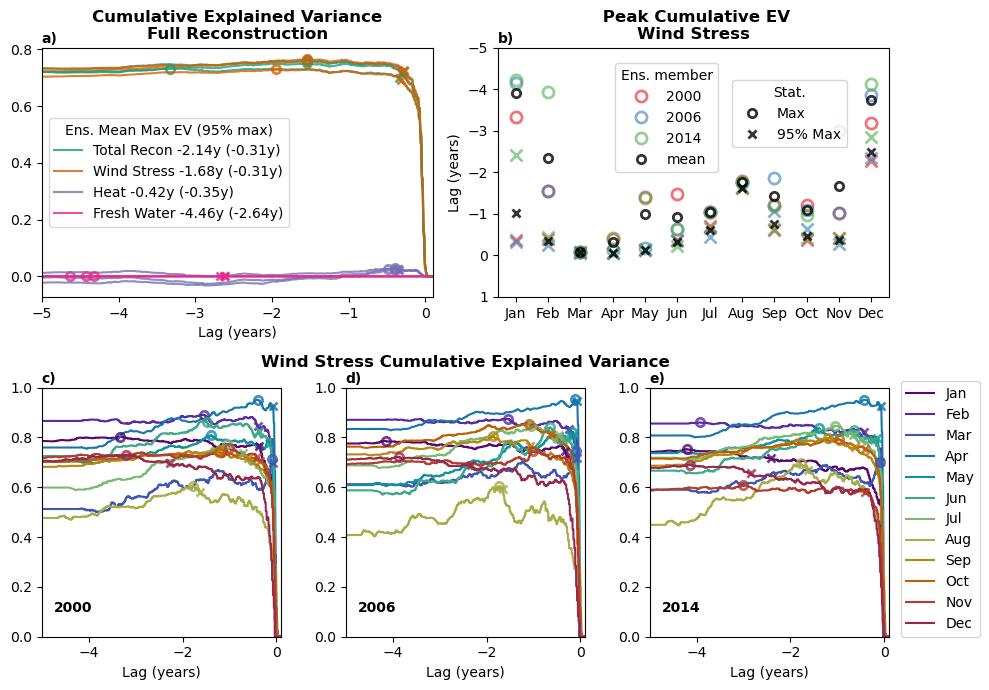

In [10]:
plt.figure(figsize=[10,7])

ax1 = plt.subplot2grid((2, 6), (0, 0), colspan=3)
colors=plt.get_cmap('Dark2')
for year in eyears:
    pps=[]
    for iv,var in enumerate(plotvars):
        p1=cum_ev[year][var].plot(label=var,color=colors(iv),alpha=0.8)
        p2=ax1.plot(lag_total[var].sel(eyear=year),ev_total[var].sel(eyear=year),'o',color=colors(iv),alpha=0.8,markeredgewidth=2,markerfacecolor='none')
        p2=ax1.plot(lagb_total[var].sel(eyear=year),evb_total[var].sel(eyear=year),'x',color=colors(iv),alpha=0.8,markeredgewidth=2,markerfacecolor='none')
        pps.append(p1[0])

plt.legend(pps,[f'{plotvar_labels[x]} {lag_total[x].mean("eyear").data:1.2f}y ({lagb_total[x].mean("eyear").data:1.2f}y)' for x in plotvars],title='Ens. Mean Max EV (95% max)')
plt.title(f'Cumulative Explained Variance\nFull Reconstruction',fontweight='bold',fontsize=12)
plt.ylabel('')
plt.xlabel('Lag (years)')
plt.xlim([-5,0.1])
plt.text(0.0,1.02,'a)',fontsize=10,fontweight='bold',transform=ax1.transAxes)

colors=plt.get_cmap('Set1')
ax2 = plt.subplot2grid((2, 6), (0, 3), colspan=3)
plot_var='wind_OCE'
pp1=[]
for iy,year in enumerate(eyears):
    pp1.append(lag_ds[plot_var].sel(eyear=year).plot(x='month',add_legend=False,color=colors(iy),marker='o',ls='',alpha=0.6,markeredgewidth=2,markerfacecolor='none',markersize=8)[0])
    pp2=lagb_ds[plot_var].sel(eyear=year).plot(x='month',add_legend=False,color=colors(iy),marker='x',ls='',alpha=0.6,markeredgewidth=2,markerfacecolor='none',markersize=8)
pp3=lag_ds[plot_var].mean('eyear').plot(x='month',add_legend=False,marker='o',ls='',markeredgewidth=2,color='k',markerfacecolor='none',alpha=0.8)[0]
pp4=lagb_ds[plot_var].mean('eyear').plot(x='month',add_legend=False,marker='x',ls='',markeredgewidth=2,color='k',alpha=0.8)[0]
plt.title(f' Peak Cumulative EV\nWind Stress',fontweight='bold',fontsize=12)
plt.ylabel('Lag (years)')
plt.ylim([1,-5])
plt.xticks(np.arange(1,13),mth)
plt.xlabel('')
l1=plt.legend(pp1+[pp3,],eyears+['mean'],title='Ens. member',loc=[0.3,0.5])
plt.legend([pp3,pp4],['Max','95% Max'],title='Stat.',loc=[0.6,0.6])
ax2.add_artist(l1)
plt.text(0.0,1.02,'b)',fontsize=10,fontweight='bold',transform=ax2.transAxes)

cmap = cmr.take_cmap_colors('cmr.infinity', 12,cmap_range=(0,0.85))
custom_cycler = cycler(color=cmap)

labels=['c)','d)','e)']
bkgd=[0.6,0.8,0.6]
for iy,year in enumerate(eyears):
    iax=plt.subplot2grid((2,6),(1,iy*2),colspan=2)
    plt.text(0.0,1.02,labels[iy],fontsize=10,fontweight='bold',transform=iax.transAxes)
    iax.set_prop_cycle(custom_cycler)
    cum_ev_bym[year][plot_var].sel(month=range(1,13)).plot(x='lag_years',hue='exp',add_legend=False)
    for imth in range(1,13):
        iax.plot(lag_ds[plot_var].sel(eyear=year,month=imth),ev_ds[plot_var].sel(eyear=year,month=imth),'o',color=cmap[imth-1],alpha=0.8,markeredgewidth=2,markerfacecolor='none')
        iax.plot(lagb_ds[plot_var].sel(eyear=year,month=imth),evb_ds[plot_var].sel(eyear=year,month=imth),'x',color=cmap[imth-1],alpha=0.8,markeredgewidth=2,markerfacecolor='none')
    plt.text(0.05,0.1,f'{year}',fontweight='bold',transform=iax.transAxes)
    plt.xlabel('Lag (years)')
    plt.ylabel('')
    plt.ylim([0,1])
    plt.xlim([-5,0.1])
    if iy==1:
        plt.title('Wind Stress Cumulative Explained Variance',fontweight='bold',y=1.05)
    else:
        plt.title('')
plt.legend(mth,loc=[1.05,0],
          )

plt.tight_layout()
plt.savefig(f'../plots/fig3_cumev_timeseries_peaks.pdf',bbox_inches='tight')